In [1]:
!pip install librosa

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 3.2 MB/s  0:00:00

   ------ --------------------------------- 1/6 [lazy_loader]
   ------------- -------------------------- 2/6 [audioread]
   -------------------- ------------------- 3/6 [soundfile]
   -------------------------- ------------- 4/6 [pooch]
   -------------------------- ------------- 4/6 [pooch]
   -------------------------- ------------- 4/6 [pooch]
   -------------------------- ------------- 4/6 [pooch]
   --------------------------------- ------ 5/6 [librosa]
   --------------------------------- ------ 5/6 [librosa]
   --------------------------------- ------ 5/6 [librosa]
   --------------------------------- ------ 5/6 [librosa]
   --------------------------------- ------ 5/6 [librosa]
   --------------------------------- ------ 5/6 [librosa]
   ------------------------

In [6]:
import numpy as np
import librosa
import scipy.signal as signal
import matplotlib.pyplot as plt
import soundfile as sf

In [3]:
def create_custom_noise_profile(duration=10.0, sample_rate=44100, overall_gain_db=-25):
    """
    Create noise based on the specific EQ profile provided
    """
    t = np.linspace(0, duration, int(duration * sample_rate))
    
    # 1. GENERATE HARMONIC HUM COMPONENT (Bands 9-13)
    fundamental_freqs = [440, 516, 645]  # Multiple fundamentals causing intermodulation
    harmonic_noise = np.zeros_like(t)
    
    # Create rich harmonic series for each fundamental
    for fundamental in fundamental_freqs:
        for harmonic in range(2, 7):  # 2nd to 6th harmonics
            freq = fundamental * harmonic
            # Add some slight detuning for realism (±1%)
            detuned_freq = freq * (1 + np.random.uniform(-0.01, 0.01))
            amplitude = 0.15 / harmonic  # Higher harmonics are quieter
            # Add slight amplitude modulation
            am_depth = 0.1
            am_rate = 0.5  # Hz
            am_modulation = 1 + am_depth * np.sin(2 * np.pi * am_rate * t)
            
            harmonic_noise += amplitude * am_modulation * np.sin(2 * np.pi * detuned_freq * t)
    
    # 2. GENERATE RESONANT PEAKS (Bands 14-16)
    resonant_freqs = [3158, 3856, 5109]
    resonant_amplitudes = [0.08, 0.08, 0.06]  # Adjusted for -30dB cuts
    resonant_noise = np.zeros_like(t)
    
    for freq, amp in zip(resonant_freqs, resonant_amplitudes):
        # Use narrow band noise instead of pure tones for realism
        white = np.random.normal(0, 1, len(t))
        # Create narrow bandpass filter around resonant frequency
        nyquist = sample_rate / 2
        low_cut = freq * 0.9 / nyquist
        high_cut = freq * 1.1 / nyquist
        b, a = signal.butter(4, [low_cut, high_cut], btype='band')
        narrow_band = signal.filtfilt(b, a, white)
        resonant_noise += amp * narrow_band
    
    # 3. GENERATE BROADBAND HISS (implied by wide Q=0.2 cuts)
    white_noise = np.random.normal(0, 1, len(t))
    
    # Apply spectral shaping to match the wide cuts
    # Design a filter that approximates the inverse of multiple wide cuts
    from scipy.signal import firwin2
    
    # Frequency points for our desired response (inverse of the cuts)
    freq_points = [0, 1000, 1290, 1548, 1858, 2229, 2675, 4000, 6000, sample_rate/2]
    # Gain response: boost where there were cuts, cut where there was boost
    gain_response = [10, 15, 15, 15, 15, 15, 15, 8, 5, 5]  # +15dB boost at harmonic frequencies
    
    # Convert to normalized frequency
    norm_freq_points = np.array(freq_points) / (sample_rate / 2)
    
    # Create FIR filter
    numtaps = 1025
    fir_coeffs = firwin2(numtaps, norm_freq_points, gain_response)
    shaped_hiss = signal.filtfilt(fir_coeffs, [1.0], white_noise)
    
    # 4. APPLY THE CHARACTERISTIC NOTCH (Band 17 - this was a BOOST in corrective EQ)
    # We need to ADD a notch at 3179Hz
    notch_freq = 3179.3
    notch_q = 4
    notch_gain = -6.6  # Inverse of the +6.6dB boost
    
    # Design notch filter
    b_notch, a_notch = signal.iirnotch(notch_freq, notch_q, sample_rate)
    
    # Combine all noise components
    combined_noise = harmonic_noise + resonant_noise + shaped_hiss
    
    # Apply the characteristic notch
    combined_noise = signal.filtfilt(b_notch, a_notch, combined_noise)
    
    # 5. NORMALIZE AND APPLY GAIN
    combined_noise = combined_noise / np.max(np.abs(combined_noise))
    gain_linear = 10 ** (overall_gain_db / 20)
    combined_noise = combined_noise * gain_linear
    
    return combined_noise

In [4]:
def analyze_noise_profile(noise_signal, sample_rate):
    """Analyze the generated noise to verify it matches target"""
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Frequency spectrum
    plt.subplot(2, 1, 1)
    freqs, psd = signal.welch(noise_signal, sample_rate, nperseg=4096)
    plt.semilogx(freqs, 10 * np.log10(psd))
    plt.xlim(100, sample_rate/2)
    plt.ylim(-80, -20)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB)')
    plt.title('Generated Noise Spectrum')
    plt.grid(True)
    
    # Mark the key frequencies from your EQ
    target_freqs = [1290, 1548, 1858, 2229, 2675, 3158, 3856, 5109, 3179]
    for freq in target_freqs:
        plt.axvline(x=freq, color='red', linestyle='--', alpha=0.3, label='Target Freq' if freq == target_freqs[0] else "")
    
    # Plot 2: Spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.stft(noise_signal[:5*sample_rate])  # First 5 seconds
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(DB, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram of Generated Noise')
    plt.tight_layout()
    plt.show()

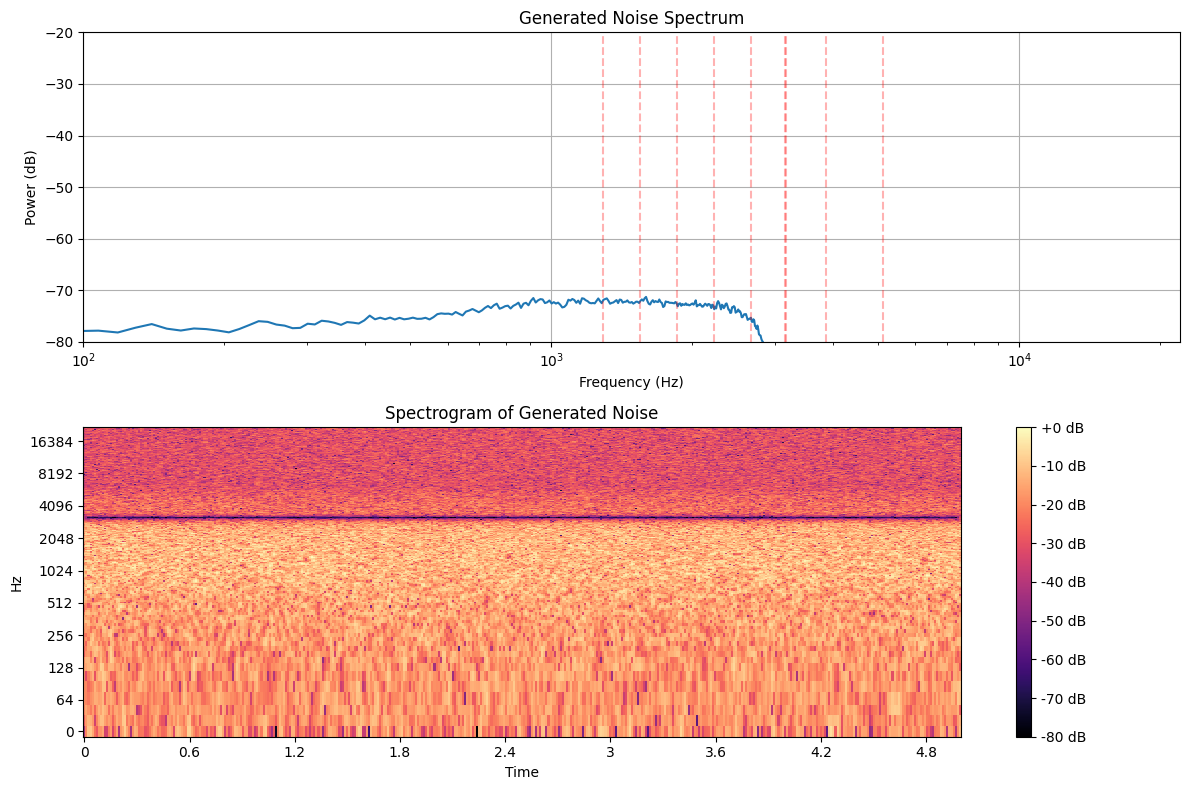

Noise generation complete!
Key features implemented:
- Harmonic series at 1290, 1548, 1858, 2229, 2675 Hz
- Resonant peaks at 3158, 3856, 5109 Hz
- Characteristic notch at 3179 Hz
- Broadband hiss with spectral shaping


In [7]:
# GENERATE AND ANALYZE
sample_rate = 44100
noise_signal = create_custom_noise_profile(duration=5.0, sample_rate=sample_rate)

# Save the result
# librosa.output.write_wav('harmonic_resonance_noise.wav', noise_signal, sample_rate)
sf.write('stereo_file1.wav', noise_signal, sample_rate, 'PCM_24')

# Analyze it
analyze_noise_profile(noise_signal, sample_rate)

print("Noise generation complete!")
print("Key features implemented:")
print("- Harmonic series at 1290, 1548, 1858, 2229, 2675 Hz")
print("- Resonant peaks at 3158, 3856, 5109 Hz") 
print("- Characteristic notch at 3179 Hz")
print("- Broadband hiss with spectral shaping")